In [17]:
# Load in packages
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [18]:
# Load in csv
df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')

# Make 'event_date' column a datetime object
train_dates = pd.to_datetime(df['event_date'])

# Select variables for training
cols = df.columns[28:30].tolist()
cols

C:\Users\tmanett\AppData\Local\Temp\ipykernel_14816\4279501191.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/tmanett/Desktop/Manifest Optimization/TML Manifest Data.csv')


['resale_price', 'face_value']

<Axes: >

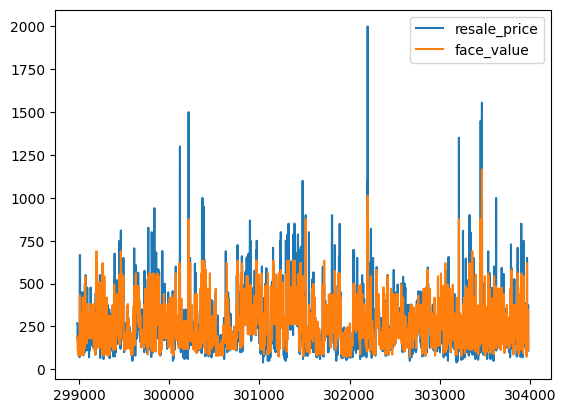

In [19]:
# Clean
df_for_training = df[cols].astype(float)

df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

In [20]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [21]:
trainX = []
trainY = []

n_future = 10
n_past = 14

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (303959, 14, 2).
trainY shape == (303959, 1).


In [22]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17152     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/5
17098/17098 [==============================] - 194s 11ms/step - loss: 0.5486 - val_loss: 1.1192
Epoch 2/5
17098/17098 [==============================] - 196s 11ms/step - loss: 0.5440 - val_loss: 1.1314
Epoch 3/5
17098/17098 [==============================] - 192s 11ms/step - loss: 0.5401 - val_loss: 1.1319
Epoch 4/5
17098/17098 [==============================] - 196s 11ms/step - loss: 0.5376 - val_loss: 1.1249
Epoch 5/5
17098/17098 [==============================] - 196s 11ms/step - loss: 0.5348 - val_loss: 1.1168


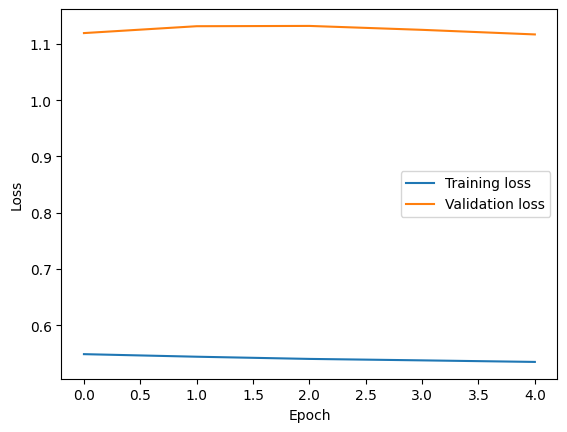

In [33]:
# Extract the loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

forecast = model.predict(trainX[-n_future:]) #forecast 

3/3 [==============================] - 1s 8ms/step


In [36]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

y_pred_future

array([260.77634, 294.91788, 307.58145, 319.65817, 324.2195 , 333.38818,
       304.43173, 310.81033, 249.22118, 242.98825, 218.43454, 223.08456,
       218.29208, 221.92052, 276.65326, 276.36035, 271.5671 , 274.5777 ,
       233.99057, 229.27615, 347.2719 , 357.1757 , 330.5426 , 313.80515,
       318.85944, 324.47702, 287.94388, 284.17554, 303.98312, 297.16068,
       234.15924, 236.73001, 233.1224 , 229.15855, 237.3382 , 241.10173,
       261.8162 , 258.63693, 274.63632, 270.1398 , 223.97137, 212.17657,
       185.18253, 195.83888, 190.00874, 185.45662, 377.9299 , 372.3796 ,
       330.3919 , 326.88367, 338.08423, 328.4289 , 303.5228 , 289.51758,
       287.59274, 284.08167, 288.04367, 288.20816, 241.91011, 240.587  ,
       278.58823, 281.5658 , 285.33032, 283.59824, 279.98743, 283.45187,
       286.16254, 285.28534, 245.89111, 244.15813, 241.59813, 241.85771,
       238.58731, 248.37651, 206.02586, 201.76172, 252.96811, 261.50867,
       273.49222, 265.33612, 216.64093, 224.18329, 

In [37]:
forecast_dates = []

C:\Users\tmanett\AppData\Local\Temp\ipykernel_14816\2612549944.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['event_date'] = pd.to_datetime(original['event_date'])


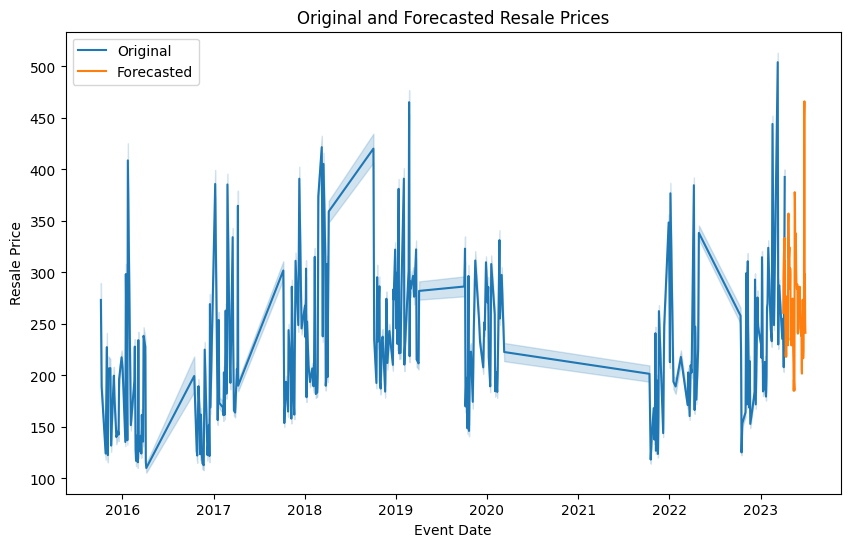

In [39]:
# Convert forecast period dates to date format
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

# Create forecast dataframe
df_forecast = pd.DataFrame({'event_date': forecast_dates, 'resale_price': y_pred_future})
df_forecast['event_date'] = pd.to_datetime(df_forecast['event_date'])

# Convert original dataframe event_date to datetime
original = df[['event_date', 'resale_price']]
original['event_date'] = pd.to_datetime(original['event_date'])

# Filter original dataframe for dates >= '2015-01-01'
original = original.loc[original['event_date'] >= pd.to_datetime('2015-01-01')]

# Plot original and forecasted resale prices
plt.figure(figsize=(10, 6))
sns.lineplot(data=original, x='event_date', y='resale_price', label='Original')
sns.lineplot(data=df_forecast, x='event_date', y='resale_price', label='Forecasted')
plt.xlabel('Event Date')
plt.ylabel('Resale Price')
plt.title('Original and Forecasted Resale Prices')
plt.legend()
plt.show()

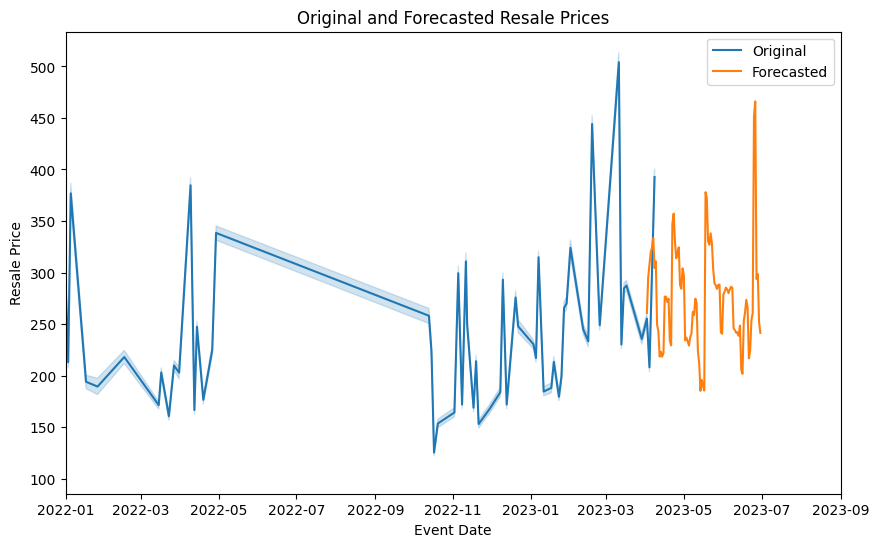

In [41]:
# Set the desired date range for zooming in
zoom_start_date = pd.to_datetime('2022-01-01')
zoom_end_date = pd.to_datetime('2023-09-01')

# Plot original and forecasted resale prices with zoom
plt.figure(figsize=(10, 6))
sns.lineplot(data=original, x='event_date', y='resale_price', label='Original')
sns.lineplot(data=df_forecast, x='event_date', y='resale_price', label='Forecasted')
plt.xlabel('Event Date')
plt.ylabel('Resale Price')
plt.title('Original and Forecasted Resale Prices')
plt.xlim(zoom_start_date, zoom_end_date)  # Set the x-axis limits
plt.legend()
plt.show()